In [1]:
import os
import csv
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr as pearr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils as utils
import torch.nn.init as init

In [2]:
ob = open('../UTMOST_pred_result_data/tiss_R/tissuewise/Liver_observed_data.txt').readlines()
ob_list = ob[0].split()

pre = open('../UTMOST_pred_result_data/predicted_Liver.txt').readlines()
pre_list = pre[0].split()

print('observed sample # :', len(ob_list), ' / ', 'predicted sample # :', len(pre_list))

count = 0
ob_idx = []       ###  column
pre_idx = []      ###  column
ref_sample = []   ###  patient name
for k1 in range(1, len(ob_list)):
    if ob_list[k1][9]=='-':
        ref = ob_list[k1][:9]
    else:
        ref = ob_list[k1][:10]
        
    for k2 in range(len(pre_list)):
        pred = pre_list[k2]
        if ref==pred:
            count += 1
#             print(ref, pred, '//', k1, k2)
            ob_idx.append(k1)
            pre_idx.append(k2)
            ref_sample.append(ref)
            
print('(UTMOST) overlaped between observed and predicted sample # :', len(ref_sample))
print(ref_sample)

observed sample # : 189  /  predicted sample # : 867
(UTMOST) overlaped between observed and predicted sample # : 184
['GTEX-1192X', 'GTEX-11DXZ', 'GTEX-11EQ9', 'GTEX-11GSP', 'GTEX-11NUK', 'GTEX-11NV4', 'GTEX-11OF3', 'GTEX-11TT1', 'GTEX-11TUW', 'GTEX-11UD2', 'GTEX-11WQC', 'GTEX-11ZTS', 'GTEX-11ZUS', 'GTEX-11ZVC', 'GTEX-1212Z', 'GTEX-12696', 'GTEX-1269C', 'GTEX-12KS4', 'GTEX-12WSD', 'GTEX-12WSG', 'GTEX-12WSI', 'GTEX-12WSL', 'GTEX-12WSM', 'GTEX-12ZZZ', 'GTEX-13112', 'GTEX-13113', 'GTEX-131XE', 'GTEX-131XH', 'GTEX-131YS', 'GTEX-132AR', 'GTEX-132NY', 'GTEX-1399R', 'GTEX-1399T', 'GTEX-139TS', 'GTEX-139TU', 'GTEX-139UC', 'GTEX-139YR', 'GTEX-13FLV', 'GTEX-13FTW', 'GTEX-13FTZ', 'GTEX-13N11', 'GTEX-13N2G', 'GTEX-13NYB', 'GTEX-13NZ9', 'GTEX-13NZB', 'GTEX-13O3O', 'GTEX-13OVJ', 'GTEX-13OW6', 'GTEX-13PVQ', 'GTEX-13PVR', 'GTEX-13QJC', 'GTEX-13SLX', 'GTEX-13VXU', 'GTEX-13X6J', 'GTEX-144GL', 'GTEX-144GM', 'GTEX-145LU', 'GTEX-145MF', 'GTEX-145MO', 'GTEX-146FH', 'GTEX-14753', 'GTEX-147F4', 'GTEX-147GR',

In [3]:
a = open('Sample_Names_by_Tissue_by_Patient.csv')
reader = csv.reader(a)

count = 0
for plink_sample in reader:
    count += 1
    if count==1:
        break
        
print(len(ref_sample), len(ob_idx), len(pre_idx), len(plink_sample))

sorted_sample = []

sorted_idx_plink = []
sorted_idx_ob = []
sorted_idx_pre = []

for k1 in range(len(ref_sample)):
    dref_sample = ref_sample[k1]
    for k2 in range(1, len(plink_sample)):
        dplink_sample = plink_sample[k2]
        
        if dref_sample==dplink_sample:
            sorted_sample.append(dref_sample)
            
            sorted_idx_plink.append(k2)
            sorted_idx_ob.append(ob_idx[k1])
            sorted_idx_pre.append(pre_idx[k1])
            
print('sorted sample # :', len(sorted_sample))
print('snp data sample index # :', len(sorted_idx_plink))
np.save('sorted_sample_idx.npy', sorted_idx_plink)

184 184 184 621
sorted sample # : 155
snp data sample index # : 155


In [4]:
gene_ob_list = []
gene_pre_list = []

for k1 in range(len(ob)):
    g1 = ob[k1].split()[0]
    gene_ob_list.append(g1)

for k2 in range(len(pre)):
    g2 = pre[k2].split()[0]
    gene_pre_list.append(g2)

print('# of genes for observed / predicted :', len(gene_ob_list), ' / ', len(gene_pre_list))

gene_ob_idx = []
gene_pre_idx = []
gene_list = []
for k1 in range(len(gene_ob_list)):
    dgene_ob = gene_ob_list[k1]
    if k1%5000==0:
        print(k1)
        
    for k2 in range(len(gene_pre_list)):
        dgene_pre = gene_pre_list[k2]
        if dgene_ob==dgene_pre: 
            gene_ob_idx.append(k1)
            gene_pre_idx.append(k2)
            gene_list.append(dgene_ob)
            
print(len(gene_ob_idx), len(gene_pre_idx), len(gene_list))

# of genes for observed / predicted : 57820  /  10165
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
10145 10145 10145


/opt/anaconda3/envs/khj/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in float_scalars
  r = r_num / r_den


9916 9916


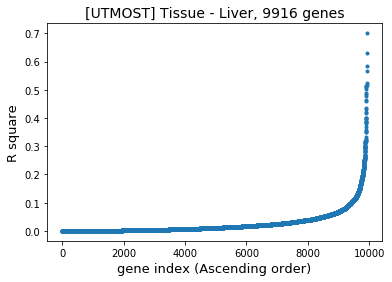

In [5]:
### check R square for all avaiilable gene
sorted_r_list = []
sorted_gene_list = []
sorted_gene_idx = []
for i in range(len(gene_list)):    
    aa = np.float32(np.array(ob[gene_ob_idx[i]].split())[sorted_idx_ob])
    bb = np.float32(np.array(pre[gene_pre_idx[i]].split())[sorted_idx_pre])
    if (np.sum(aa)*0 != 0) or (np.sum(bb)*0 != 0):
        continue
        
    r, p = pearr(aa, bb)
    if (r**2)*0!=0:
#         plt.plot(bb, aa,'*')
#         plt.title('R squre : %.4f / p %.4f'%(r**2, p))
#         plt.show()
        continue
    
    sorted_r_list.append(r**2)
    sorted_gene_list.append(gene_list[i])
    sorted_gene_idx.append(i)
        
print(len(sorted_r_list), len(sorted_gene_list))
plt.title('[UTMOST] Tissue - Liver, %d genes'%len(sorted_r_list),fontsize=14)
plt.plot(np.array(sorted_r_list)[np.argsort(sorted_r_list)], '.')
plt.xlabel('gene index (Ascending order)', fontsize=13)
plt.ylabel('R square', fontsize=13)
plt.savefig('img/UTMOST_allgene_Rsqr.png')
plt.show()

In [19]:
#### over 0.2 R^2 sorting code ##########

sorted_r_list = []
sorted_gene_list = []
sorted_gene_idx = []
for i in range(len(gene_list)): 
    aa = np.float32(np.array(ob[gene_ob_idx[i]].split())[sorted_idx_ob])
    bb = np.float32(np.array(pre[gene_pre_idx[i]].split())[sorted_idx_pre])
    if (np.sum(aa)*0 != 0) or (np.sum(bb)*0 != 0):
        continue
        
    r, p = pearr(aa, bb)
    if (r**2)*0!=0:
        continue

    sorted_r_list.append(r**2)
    sorted_gene_list.append(gene_list[i])
    sorted_gene_idx.append(i)
        
print(len(sorted_r_list), len(sorted_gene_list))

top2_idx = np.argsort(sorted_r_list)[-500:]
top2_r_list = np.array(sorted_r_list)[top2_idx]
top2_gene_list = np.array(sorted_gene_list)[top2_idx]
for k in range(4,len(top2_gene_list),5):
    print(top2_gene_list[k])#, ' = ', round(top2_r_list[k], 4))
    
top2_dict = dict(zip(top2_gene_list, top2_r_list))
print(top2_dict)

json.dump(top2_dict, open('top500_over100_name2rsqr.json','w'))

9916 9916
CHI3L1
CNTNAP2
EFCAB13
NPIPA8
HSF2BP
KLRC2
MARCH2
C21orf90
NTPCR
CD22
SLC17A8
SMLR1
EPSTI1
CDH23
C21orf119
CARS2
XRCC6BP1
TGDS
SLC10A4
CRYBB3
SPTLC3
NPBWR1
TMEM45B
TMEM41A
OXER1
PPIF
NIPAL1
NAPG
SRR
ZNF559
CYP7B1
ZNF514
HTR7
GLDC
SAA2
AGAP4
MGST1
SPDYC
H3F3A
SPTY2D1
CTAGE8
TBC1D9B
CYP4V2
ABCB11
CDHR5
EMC9
GALK1
KNSTRN
GPR17
SMC6
NYNRIN
CNGA1
MOGS
CYP3A5
SLC44A5
TEN1
NUP85
LRRC37A2
HBD
ABCA5
FAM184A
SHBG
TEKT5
ATP6AP1L
TMEM176A
TTC12
ZNF682
PSMD5
TREH
FLYWCH1
IL22RA1
ENPP7
RHD
STOX1
MBL2
IRAK1BP1
MTG2
C1GALT1
RBFA
ATG10
ACSF3
WBSCR27
SOX6
TTC32
GALR3
LRRC23
ARHGEF28
RPS26
ALG1L
SRD5A3
FBLL1
GLIPR1L2
USP43
NPHP4
PRMT6
ZP3
GSTT2B
OR7D2
DOPEY2
FAM118A
{'ESPL1': 0.10026314782154433, 'TMCO6': 0.10028687312298246, 'FAM173A': 0.10071947801197112, 'RPS6KL1': 0.10101264821170819, 'CHI3L1': 0.10114084392683154, 'TPSG1': 0.10124493834359782, 'RANBP17': 0.10143094354926863, 'CRIP3': 0.10146498296195716, 'SIGLEC12': 0.10147172317715647, 'CNTNAP2': 0.1016465532656321, 'UROS': 0.101708703182

In [15]:
#### over 0.2 R^2 sorting code ##########
np.random.seed(37)

sorted_r_list = []
sorted_gene_list = []
sorted_gene_idx = []
for i in range(len(gene_list)): 
    aa = np.float32(np.array(ob[gene_ob_idx[i]].split())[sorted_idx_ob])
    bb = np.float32(np.array(pre[gene_pre_idx[i]].split())[sorted_idx_pre])
    if (np.sum(aa)*0 != 0) or (np.sum(bb)*0 != 0):
        continue
        
    r, p = pearr(aa, bb)
    if (r**2)*0!=0:
        continue

    sorted_r_list.append(r**2)
    sorted_gene_list.append(gene_list[i])
    sorted_gene_idx.append(i)
        
print(len(sorted_r_list), len(sorted_gene_list))

rand_idx = np.random.randint(0,9915,1000)
rand_r_list = np.array(sorted_r_list)[rand_idx]
rand_gene_list = np.array(sorted_gene_list)[rand_idx]
for k in range(len(rand_gene_list)):
    print(rand_gene_list[k])#, ' = ', round(top2_r_list[k], 4))
    
rand_dict = dict(zip(rand_gene_list, rand_r_list))
print(rand_dict)

json.dump(rand_dict, open('rand1000_name2rsqr.json','w'))

9916 9916
SPATA6L
NEDD1
FAM114A1
ERO1LB
VILL
PINK1
GPT2
C16orf13
KCTD21
LHPP
SMCHD1
THOC3
FAM134A
SEPHS1
UCHL5
NSFL1C
THAP5
PHF20
STARD13
ENKUR
UBAC2
ATG7
RPL15
AMACR
AUNIP
PDCD10
SLC7A5
CLEC1A
UMODL1
BEAN1
NMT2
WDR36
PCYOX1L
MAP3K6
SIGIRR
AKAP1
MDH1B
PBXIP1
DCXR
CYP26B1
GMEB1
MTIF2
USB1
HARS
RPS3
SELENBP1
VPS37D
RUSC1
SEC11A
TPMT
ITGA9
LOXL1
ARHGAP21
TMEM161A
PPP4R4
CCDC102A
TXNDC15
PAG1
RPS21
ADAM8
RIT1
PPA2
XRCC2
MRTO4
RASL11A
MED21
FAM71F2
C21orf91
TRAF1
GNG12
ETF1
CREB3
RNPC3
SMYD2
ZNF410
ARFRP1
RNF6
GIGYF1
HACL1
CROCC
ZNF704
EPSTI1
ZNF467
SCNN1A
NR4A2
SAP130
C21orf59
EPHB4
HSPE1
FAM217B
CCDC94
DIMT1
HRAS
TMEM60
ZC3H8
DDX56
TM9SF4
TTC30A
SNF8
NDUFAF6
PKD2L1
ATP6V0E1
SLC30A9
EPRS
RPH3AL
DISP2
PDCD7
FAM91A1
SUCLA2
UBE2E2
PPP1R14B
FGFR1OP
TPRG1
NSMF
LRIF1
FAM194B
TMOD3
TMEM74
USE1
SPAG7
GNA14
ITGA9
LDOC1L
DIDO1
MYO1E
ZNF829
CKS1B
FLVCR2
ARHGEF7
MAPK11
HMGXB4
PIK3CB
WDR92
COPZ2
CGNL1
MYRF
CORO2A
STK36
ZNF329
ASNA1
COG4
NAA40
ZNF620
INTS1
GNRH1
GSTZ1
RASSF1
MAPKBP1
MAGEF1
TMEM185B
ETS2